<a href="https://colab.research.google.com/github/scaairesearch/da_cv_fer/blob/main/experiment_model_improvement_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Objective
 - creating versions for non_dann, dann and dann_ewc
 - Previously from v3
  - Improve accuracy of base model - classification task
  - use basic pretrained models to check accuracy - https://www.robots.ox.ac.uk/~albanie/pytorch-models.html - VGG vgg_vd_face_sfew (weights)

Observations
  - Previously from v3 / v5
    - can achieve more than 51% accuracy
    - lr of 0.001 gives good accuarcy

Next Steps
  - lr finder
  - SE inclusion
  
Models
  - non-dann (non_dann_sfew_expw_08_04.pt)
    - sota for non-dann
    - SFEW Val: Average loss: 0.1262, Accuracy: 236/419 (56.32%)
  - dann (dann_sfew_expw_08_04.pt)
    - sota for dann
    - SFEW Val: Average loss: 0.1031, Accuracy: 223/419 (53.22%)
    - EXPW Val (RaceDataset): Average loss: 0.2015, Accuracy: 2470/8603 (28.71%)
  - ewc dann(ewc_dann_sfew_expw_08_04.pt)
    - sota for ewc dann
    - SFEW Val: Average loss: 0.1414, Accuracy: 234/419 (55.85%)
    - EXPW Val (RaceDataset): Average loss: 0.3540, Accuracy: 2580/8603 (29.99%)


## Initializations
Cloning Repo, Dependencies installation, Libraries import and Config Initialization

### Cloning Repo, Installing dependencies

In [1]:
!git clone https://github.com/scaairesearch/da_cv_fer
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 461, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 461 (delta 137), reused 157 (delta 81), pack-reused 209
Receiving objects: 100% (461/461), 31.13 MiB | 26.94 MiB/s, done.
Resolving deltas: 100% (251/251), done.


In [2]:
!pip install -q -r requirements.txt # -q is for quiet install
# for some reason the below does not get installed with requirements
!pip install -q opendatasets
!pip install -q facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.7/301.7 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.7/225.7 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [3]:
# Installs from files
from da_cv_fer.data_config import DataConfig
# from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_sfew_crop import DatasetSFEWCROP
# from da_cv_fer.ds_expw_crop import EXPWCROP
# from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import *
# from da_cv_fer.model_DANN import DANN
# from da_cv_fer.model_DANN_Bespoke import DANNBespoke
from da_cv_fer.run_config import RunConfig
# from da_cv_fer.train import *
import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np


### Initializing Configs

In [4]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

##  Dataset - Source
- SFEW Dataset
- Creating Dataloader object


In [5]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Creating Dataloader

In [6]:
sfew = DatasetSFEWCROP()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

 self.BASE_PATH -dataset, 
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew created successfully.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Fear.zip Fear
...completed for dataset/sfew/Train/Fear.zip
dataset/sfew/Train Sad.zip Sad
...completed for dataset/sfew/Train/Sad.zip
dataset/sfew/Train Neutral.zip Neutral
...completed for dataset/sfew/Train/Neutral.zip
dataset/sfew/Train Surprise.zip Surprise
...completed for dataset/sfew/Train/Surprise.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/Angry.zip
dataset/sfew/Train Happy.zip Happy
...completed for dataset/sfew/Train/Happy.zip
da

### Example Images

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


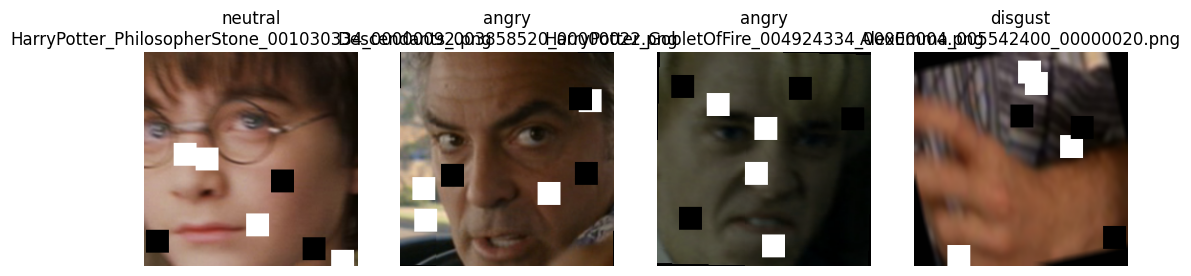

In [7]:
show_batch(sfew_train_loader,sfew.labels,4, normalized = False)

In [ ]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
data_loader = {'source' : sfew_loader}
source_name = data_loader['source']['name']

## Model Initialization

### Simple Model_V5
- including dann
- including grl
- including GAP

In [ ]:

import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F


class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model

In [ ]:
model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

In [ ]:
model_pretrained

Vgg_vd_face_sfew_dag(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool1): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool2): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU()
  (pool3): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_m

In [ ]:
list(model_pretrained.children())[-4:-1]

[ReLU(), Linear(in_features=4096, out_features=4096, bias=True), ReLU()]

In [ ]:
import torch.nn as nn
import torch
from torch.autograd import Function
import torch.nn.functional as F

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG, self).__init__()
        #---------------------Feature Extractor Network------------------------#
        self.feature_extractor = nn.Sequential(*list(model_pretrained.children())[:-4])

        #---------------------Class Classifier------------------------#
        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        # self.class_classifier = nn.Sequential(*list(model_pretrained.children())[-4:])
        self.class_classifier = nn.Sequential(*list_class_classifer)



        #---------------------Domain Classifier------------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features


In [ ]:
model = DANN_VGG(model_pretrained = model_pretrained, num_classes=7)
from torchsummary import summary  #for model summary and params
print(model)

DANN_VGG(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256,

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
from torchsummary import summary

summary(model.to(device), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# !pip install torch-summary

In [ ]:
# from torchsummary import summary
# summary(model, (3, 224, 224), col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds"], verbose =2 )

## Checking accuracy before fine tuning

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [ ]:
model = model.to(device=device)

### Test Function

In [ ]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [ ]:
def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images*255)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss

#### Pre fine train metric

In [ ]:
correct, test_loss = test_model_local(model, device, data_loader['source']['val'], mode= 'test')
correct, test_loss

Test / Val: Average loss: 0.5718, Accuracy: 108/419 (25.78%)



(108, 0.5718486815477613)

### Train Function

#### Basic Training Function

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn.functional as F

def train_model_local(model, train_loader, criterion, optimizer, device='cuda'):
    model.to(device)
    model.train()
    # for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0

    for inputs, labels,_ in train_loader:
        inputs = inputs * 255.0  # Convert inputs from [0, 1] to [0, 255]
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs,_,_ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        correct += get_correct_preds(outputs, labels)


    epoch_loss = running_loss / len(train_loader.dataset)
    length_dataset = len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy : {correct}/{length_dataset} Or {100. * correct / length_dataset: .2f} %')

    return



#### Training Function with LR Scheduler

In [ ]:
def train_model_local_lr(model,device, data_loader, optimizer, epoch,
                class_loss_function = nn.CrossEntropyLoss() ):
    print(f'epoch = {epoch+1}...in training function')
    model.to(device)
    model.train() # setting model to training


    pbar = tqdm(data_loader) # putting the dataloader in progress bar

    processed = 0 # to understand accuracy, used in denominator
    epoch_loss = 0.0
    correct = 0

    for batch_idx, batch in enumerate(pbar):
        batch[0] = batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]
        images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels


        optimizer.zero_grad() # setting gradients to zero to avoid accumulation

        class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

        class_loss = class_loss_function(class_output,labels) # Calculate Loss
        epoch_loss += class_loss.item()
        # Sum up batch correct predictions
        correct += get_correct_preds(class_output, labels)

        class_loss.backward() #backpropogation, creating gradients

        optimizer.step() # updating the params

        processed += len(images)
        curr_lr = optimizer.param_groups[0]['lr']

        pbar.set_description(desc= f'Loss={class_loss.item()} Accuracy={correct}/{processed}({100*correct/processed:0.2f}%) Epoch Avg loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')

    return float("{:.8f}".format(epoch_loss/processed)),  curr_lr


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Execution without Learning Rate

In [ ]:
# num_epochs=55
# for epoch in range(num_epochs):
#   train_model_local(model = model, train_loader = data_loader['source']['train'], criterion = criterion, optimizer=optimizer)
#   test_model_local(model, device, data_loader['source']['val'], class_loss_function= criterion, mode= 'test')
# print('Training finished.')

### Execution with LR

In [ ]:
runconfig = RunConfig()
device = runconfig.device

model = DANN_VGG(model_pretrained = model_pretrained, num_classes=7).to(device=device)
best_model = DANN_VGG(model_pretrained = model_pretrained, num_classes=7).to(device=device)

#learning rate
lr =  0.001 #float(runconfig.inital_lr)

# Epochs
EPOCHS = runconfig.NUM_EPOCHS
# EPOCHS = 2 #override
print("EPOCHS", EPOCHS)

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# optimizer
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)

#optimizer with weight decay (L2 regularization)
# optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9, weight_decay= 0.0001)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

# Initialize variables to track the best validation loss and the best model state
best_val_loss = float('inf')
best_val_acc = 0
best_model_state = None

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
# criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs
lr_schedule = [] # to capture learning rate over epochs
epoch_converge = 0 #TODO: run config based
list_val_correct = [] # to capture validation accuracy over epochs
list_best_val_correct = [] # to capture best validtion accuracy over epochs

EPOCHS 150


------ Training started for Non DANN Model ---- 
starting LR : 0.001
EPOCH: 1  of  150
epoch = 1...in training function


Loss=2.4378647804260254 Accuracy=377/913(41.29%) Epoch Avg loss=0.09798591 LR=0.001000: 100%|██████████| 58/58 [00:24<00:00,  2.33it/s]


Test / Val: Average loss: 0.1032, Accuracy: 176/419 (42.00%)

last correct =176 | best correct = 0
Updated the best model with correct: 176



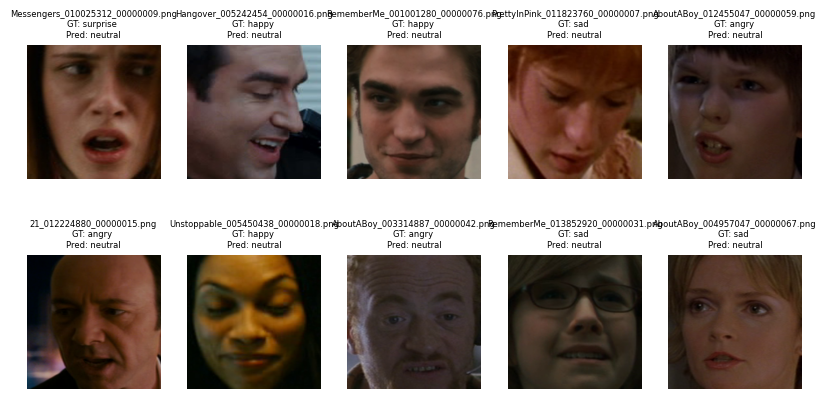

EPOCH: 2  of  150
epoch = 2...in training function


Loss=2.357987880706787 Accuracy=438/913(47.97%) Epoch Avg loss=0.09374026 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.0990, Accuracy: 192/419 (45.82%)

last correct =192 | best correct = 176
Updated the best model with correct: 192

EPOCH: 3  of  150
epoch = 3...in training function


Loss=1.0884196758270264 Accuracy=446/913(48.85%) Epoch Avg loss=0.09083566 LR=0.001000: 100%|██████████| 58/58 [00:24<00:00,  2.33it/s]


Test / Val: Average loss: 0.1085, Accuracy: 190/419 (45.35%)

last correct =190 | best correct = 192
EPOCH: 4  of  150
epoch = 4...in training function


Loss=3.6510496139526367 Accuracy=495/913(54.22%) Epoch Avg loss=0.08430055 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1176, Accuracy: 167/419 (39.86%)

last correct =167 | best correct = 192
EPOCH: 5  of  150
epoch = 5...in training function


Loss=2.098769187927246 Accuracy=401/913(43.92%) Epoch Avg loss=0.09997266 LR=0.001000: 100%|██████████| 58/58 [00:24<00:00,  2.32it/s]


Test / Val: Average loss: 0.1119, Accuracy: 172/419 (41.05%)

last correct =172 | best correct = 192
EPOCH: 6  of  150
epoch = 6...in training function


Loss=0.9280574917793274 Accuracy=420/913(46.00%) Epoch Avg loss=0.09346119 LR=0.001000: 100%|██████████| 58/58 [00:24<00:00,  2.33it/s]


Test / Val: Average loss: 0.1025, Accuracy: 173/419 (41.29%)

last correct =173 | best correct = 192
EPOCH: 7  of  150
epoch = 7...in training function


Loss=0.022141631692647934 Accuracy=481/913(52.68%) Epoch Avg loss=0.08163036 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.29it/s]


Test / Val: Average loss: 0.0993, Accuracy: 208/419 (49.64%)

last correct =208 | best correct = 192
Updated the best model with correct: 208

EPOCH: 8  of  150
epoch = 8...in training function


Loss=1.3087677955627441 Accuracy=567/913(62.10%) Epoch Avg loss=0.07105491 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.27it/s]


Test / Val: Average loss: 0.1036, Accuracy: 191/419 (45.58%)

last correct =191 | best correct = 208
EPOCH: 9  of  150
epoch = 9...in training function


Loss=0.20404700934886932 Accuracy=572/913(62.65%) Epoch Avg loss=0.06763498 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.27it/s]


Test / Val: Average loss: 0.1114, Accuracy: 207/419 (49.40%)

last correct =207 | best correct = 208
EPOCH: 10  of  150
epoch = 10...in training function


Loss=0.30756884813308716 Accuracy=595/913(65.17%) Epoch Avg loss=0.06469875 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.23it/s]


Test / Val: Average loss: 0.1017, Accuracy: 211/419 (50.36%)

last correct =211 | best correct = 208
Updated the best model with correct: 211

EPOCH: 11  of  150
epoch = 11...in training function


Loss=5.095411777496338 Accuracy=607/913(66.48%) Epoch Avg loss=0.06714390 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.25it/s]


Test / Val: Average loss: 0.1024, Accuracy: 198/419 (47.26%)

last correct =198 | best correct = 211


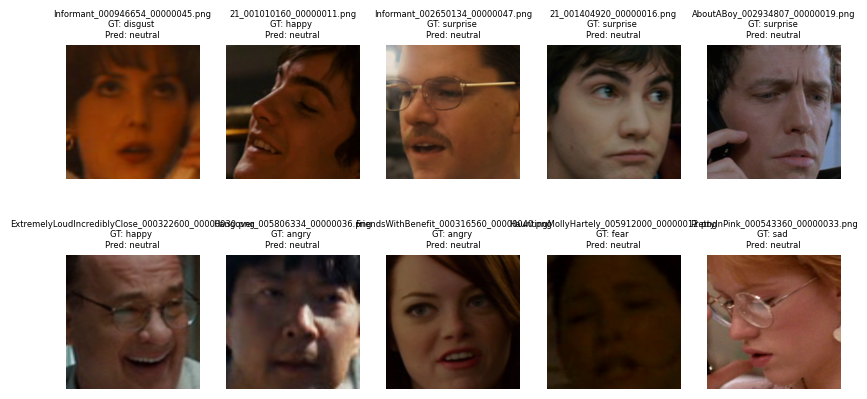

EPOCH: 12  of  150
epoch = 12...in training function


Loss=0.7296536564826965 Accuracy=561/913(61.45%) Epoch Avg loss=0.07071839 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.27it/s]


Test / Val: Average loss: 0.1118, Accuracy: 194/419 (46.30%)

last correct =194 | best correct = 211
EPOCH: 13  of  150
epoch = 13...in training function


Loss=1.4662926197052002 Accuracy=586/913(64.18%) Epoch Avg loss=0.06542850 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.29it/s]


Test / Val: Average loss: 0.1011, Accuracy: 194/419 (46.30%)

last correct =194 | best correct = 211
EPOCH: 14  of  150
epoch = 14...in training function


Loss=1.061523675918579 Accuracy=656/913(71.85%) Epoch Avg loss=0.05143904 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.32it/s]


Test / Val: Average loss: 0.1094, Accuracy: 211/419 (50.36%)

last correct =211 | best correct = 211
EPOCH: 15  of  150
epoch = 15...in training function


Loss=1.4165778160095215 Accuracy=597/913(65.39%) Epoch Avg loss=0.06527490 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.1063, Accuracy: 190/419 (45.35%)

last correct =190 | best correct = 211
EPOCH: 16  of  150
epoch = 16...in training function


Loss=0.5565500855445862 Accuracy=657/913(71.96%) Epoch Avg loss=0.05110445 LR=0.001000: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1276, Accuracy: 208/419 (49.64%)

last correct =208 | best correct = 211
EPOCH: 17  of  150
epoch = 17...in training function


Loss=0.02243751659989357 Accuracy=718/913(78.64%) Epoch Avg loss=0.04328204 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1159, Accuracy: 218/419 (52.03%)

last correct =218 | best correct = 211
Updated the best model with correct: 218

EPOCH: 18  of  150
epoch = 18...in training function


Loss=-0.0 Accuracy=743/913(81.38%) Epoch Avg loss=0.03381849 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1238, Accuracy: 222/419 (52.98%)

last correct =222 | best correct = 218
Updated the best model with correct: 222

EPOCH: 19  of  150
epoch = 19...in training function


Loss=0.06814800202846527 Accuracy=766/913(83.90%) Epoch Avg loss=0.03227060 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1196, Accuracy: 228/419 (54.42%)

last correct =228 | best correct = 222
Updated the best model with correct: 228

EPOCH: 20  of  150
epoch = 20...in training function


Loss=0.015284435823559761 Accuracy=776/913(84.99%) Epoch Avg loss=0.02895003 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1179, Accuracy: 226/419 (53.94%)

last correct =226 | best correct = 228
EPOCH: 21  of  150
epoch = 21...in training function


Loss=0.03536853566765785 Accuracy=790/913(86.53%) Epoch Avg loss=0.02585257 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1221, Accuracy: 232/419 (55.37%)

last correct =232 | best correct = 228
Updated the best model with correct: 232



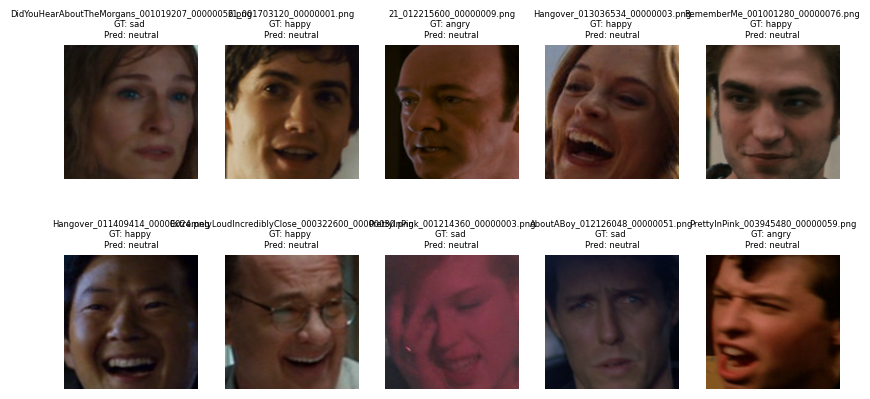

EPOCH: 22  of  150
epoch = 22...in training function


Loss=0.003969884943217039 Accuracy=783/913(85.76%) Epoch Avg loss=0.02829224 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.1268, Accuracy: 215/419 (51.31%)

last correct =215 | best correct = 232
EPOCH: 23  of  150
epoch = 23...in training function


Loss=0.0004068977141287178 Accuracy=801/913(87.73%) Epoch Avg loss=0.02567566 LR=0.000200: 100%|██████████| 58/58 [00:26<00:00,  2.21it/s]


Test / Val: Average loss: 0.1155, Accuracy: 227/419 (54.18%)

last correct =227 | best correct = 232
EPOCH: 24  of  150
epoch = 24...in training function


Loss=0.6946491599082947 Accuracy=804/913(88.06%) Epoch Avg loss=0.02318517 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.25it/s]


Test / Val: Average loss: 0.1304, Accuracy: 234/419 (55.85%)

last correct =234 | best correct = 232
Updated the best model with correct: 234

EPOCH: 25  of  150
epoch = 25...in training function


Loss=0.016356086358428 Accuracy=798/913(87.40%) Epoch Avg loss=0.02481203 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.25it/s]


Test / Val: Average loss: 0.1179, Accuracy: 226/419 (53.94%)

last correct =226 | best correct = 234
EPOCH: 26  of  150
epoch = 26...in training function


Loss=4.172316494077677e-06 Accuracy=783/913(85.76%) Epoch Avg loss=0.02483880 LR=0.000200: 100%|██████████| 58/58 [00:26<00:00,  2.22it/s]


Test / Val: Average loss: 0.1247, Accuracy: 232/419 (55.37%)

last correct =232 | best correct = 234
EPOCH: 27  of  150
epoch = 27...in training function


Loss=0.0002540027489885688 Accuracy=810/913(88.72%) Epoch Avg loss=0.02038060 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.29it/s]


Test / Val: Average loss: 0.1255, Accuracy: 227/419 (54.18%)

last correct =227 | best correct = 234
EPOCH: 28  of  150
epoch = 28...in training function


Loss=0.00026770823751576245 Accuracy=796/913(87.19%) Epoch Avg loss=0.02122641 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.29it/s]


Test / Val: Average loss: 0.1283, Accuracy: 236/419 (56.32%)

last correct =236 | best correct = 234
Updated the best model with correct: 236

EPOCH: 29  of  150
epoch = 29...in training function


Loss=0.08212768286466599 Accuracy=806/913(88.28%) Epoch Avg loss=0.02389305 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.31it/s]


Test / Val: Average loss: 0.1208, Accuracy: 221/419 (52.74%)

last correct =221 | best correct = 236
EPOCH: 30  of  150
epoch = 30...in training function


Loss=0.03073836676776409 Accuracy=834/913(91.35%) Epoch Avg loss=0.01738491 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.32it/s]


Test / Val: Average loss: 0.1419, Accuracy: 229/419 (54.65%)

last correct =229 | best correct = 236
EPOCH: 31  of  150
epoch = 31...in training function


Loss=3.5072028636932373 Accuracy=824/913(90.25%) Epoch Avg loss=0.02200907 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.30it/s]


Test / Val: Average loss: 0.1361, Accuracy: 222/419 (52.98%)

last correct =222 | best correct = 236


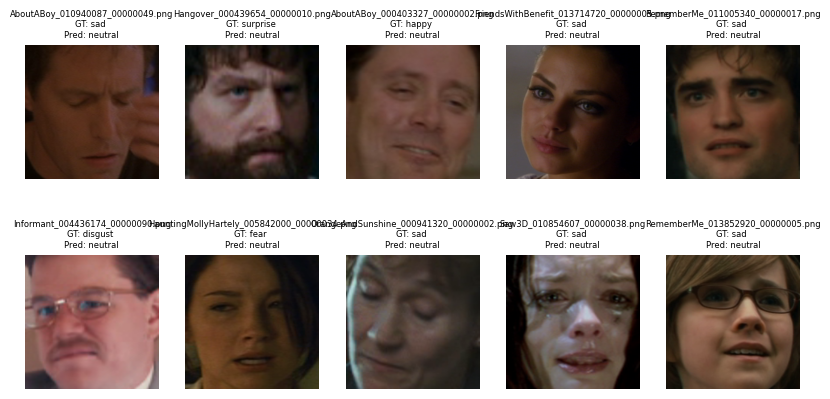

EPOCH: 32  of  150
epoch = 32...in training function


Loss=0.00012420836719684303 Accuracy=819/913(89.70%) Epoch Avg loss=0.01999974 LR=0.000200: 100%|██████████| 58/58 [00:25<00:00,  2.27it/s]


Test / Val: Average loss: 0.1337, Accuracy: 223/419 (53.22%)

last correct =223 | best correct = 236
-------Early Stopping at epoch 32---
Best model loaded
Validation results with sfew
Test / Val: Average loss: 0.1262, Accuracy: 236/419 (56.32%)



In [ ]:
# Training block
print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, " of ", EPOCHS)

    #Train Model
    avg_epoch_loss, curr_lr = train_model_local_lr (model = model,
                                          device = device,
                                          data_loader = data_loader['source']['train'],
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    lr_schedule.append(curr_lr)

    #Validate Model
    correct, avg_epoch_val_loss = test_model_local(model= model,
                                    device= device,
                                    data_loader = data_loader['source']['val'],
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)
    list_val_correct.append(correct)

    #Adding Scheduler #TODO: ADD SCHEDULER
    scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct

    # # Check if the current model has the best validation loss
    # print(f'Last Epoch Val Loss = {avg_epoch_val_loss} | Best Val Loss = {best_val_loss}' )
    # if avg_epoch_val_loss < best_val_loss:
    #   best_val_loss = avg_epoch_val_loss
    #   # save the current model state as the best model state
    #   best_model_state = deepcopy(non_dann_model.state_dict())
    #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

    # check if the current model has the best accuracy
    print (f'last correct ={correct} | best correct = {best_val_acc}')
    if correct > best_val_acc:
      best_val_acc = correct
      # save the current model state as the best model state
      best_model_state = deepcopy(model.state_dict())
      print(f'Updated the best model with correct: {correct}\n')

    list_best_val_correct.append(best_val_acc)

    # early stopping
    # if early_stopping_difference(val_losses,
    #                              patience = early_stop_patience,
    #                              difference= early_stop_difference):
    #   print (f'-------Early Stopping at epoch {epoch+1}---')
    #   epoch_converge = epoch+1
    #   break

    if early_stopping_difference(list_val_correct,
                                 patience = early_stop_patience,
                                 difference= early_stop_difference):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break

    if early_stopping_difference(list_best_val_correct,
                                 patience = 2*early_stop_patience,
                                 difference= 0):
      print (f'-------Early Stopping at epoch {epoch+1}---')
      epoch_converge = epoch+1
      break



    ## showing misclassification images after every 10 epochs
    if epoch % 10 == 0:
      list_misclassified_images = get_misclassified_images_list(model= model,
                                                                device = device,
                                                                test_loader = data_loader['source']['val'],
                                                                num_image = 10)
      plot_misclassified_images(list_misclassified_images)

## using params of best model to update model
if best_model_state: # only update if best model has been saved, else the last one would be picked up
  # best_non_dann_model.load_state_dict(best_model_state)
  best_model.load_state_dict(best_model_state)
  print('Best model loaded')


print(f'Validation results with {source_name}')

correct, test_loss_source = test_model_local(model= best_model, #best_non_dann_model, #non_dann_model,
                                    device= device,
                                    data_loader = data_loader['source']['val'], # source val loader
                                    class_loss_function = criterion_class)





dict_non_dann_losses = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                      #  'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : epoch_converge,
                                       'lr': lr_schedule}


### Saving Non-Dann Model

In [ ]:
target_name = 'expw'
MODEL_DIR = dataconfig.MODEL_DIR
NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
SPECIFIC_MODEL_DIR = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}'))
print(MODEL_DIR, NON_DANN_SFEW_DIR, SPECIFIC_MODEL_DIR)

/content/gdrive/MyDrive/CV_FER/models /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw


In [ ]:
model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not SPECIFIC_MODEL_DIR.exists():
    # Create the directory
    SPECIFIC_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {SPECIFIC_MODEL_DIR} created successfully.')
else:
    print(f'Directory {SPECIFIC_MODEL_DIR} already exists.')

torch.save(best_model.state_dict(), Path(SPECIFIC_MODEL_DIR,model_name))

Directory /content/gdrive/MyDrive/CV_FER/models/non_dann_sfew_expw already exists.


## Dataset - Target

- EXPW dataset

In [8]:
# checking the mounted drive and mounting if not done
import os
if not os.path.exists('/content/gdrive'):
  from google.colab import drive
  drive.mount('/content/gdrive')
else:
    print("Google Drive is already mounted.")


Google Drive is already mounted.


### Creating Dataloader for EXPW

In [9]:
from da_cv_fer.ds_expw_crop import EXPWCROP

expw_obj = EXPWCROP()

expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

desitination file path = dataset/expwds/expwds.zip
Directory dataset/expwds created successfully.


100%|██████████| 7.68G/7.68G [01:13<00:00, 112MB/s]



File downloaded successfully from https://www.kaggle.com/datasets/mohammedaaltaha/expwds to dataset/expwds/expwds.zip
Unzipped Files already exist in dataset/expwds, not extracted
---NOT CROPPING AT RUNTIME--
 before splitting : image_label_dict 68096
*** Starting creation of dataset based on RACE data ***
pickle_file_path:  /content/gdrive/MyDrive/CV_FER/dataset/expw_raceds_image_dict.pkl
train list [('amazed_president_8.jpg', 5), ('fighting_mother_419.jpg', 6)] <class 'list'> 1000
size of dataset (list_img_label): 1000
*** Completed creation of dataset based on RACE data ***
---NOT CROPPING AT RUNTIME--, flag_create_crop_contents value: False
Directory created: dataset/expwds/cropped
**** dataset/expwds/cropped is empty***

 
23 were not able to crop
977 cropped images created in cropped
---NOT CROPPING AT RUNTIME--
 before splitting : image_label_dict 68096
*** Starting creation of dataset based on RACE data ***
pickle_file_path:  /content/gdrive/MyDrive/CV_FER/dataset/expw_raceds_

In [10]:
if expw_train_loader is None:
  sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }
  data_loader = {'source' : sfew_loader}
  source_name = data_loader['source']['name']
  target_name = "expw"
else:
  sfew_loader = {'name': 'sfew',
                'train':sfew_train_loader,
                'val':sfew_val_loader
                }

  expw_loader = {'name': 'expw',
                'train':expw_train_loader,
                'val':expw_val_loader
                }

  data_loader = {'source' : sfew_loader,
                'target' : expw_loader}

  source_name = data_loader['source']['name']
  target_name = data_loader['target']['name']

## Loading NON DANN Model for DANN and DANN EWC


In [51]:

today_model_name = f'non_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # Typical - non_dann_sfew_expw_30_01.pt This may change, use specific model name if required4
print(f'today_model_name {today_model_name}')
custom_model_name= 'non_dann_sfew_expw_08_04.pt'
print(f'custom_model_name {custom_model_name}')
model_name = custom_model_name

today_model_name non_dann_sfew_expw_11_04.pt
custom_model_name non_dann_sfew_expw_08_04.pt


In [52]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [53]:

import torch
import torch.nn as nn
from torch.autograd import Function
import torch.nn.functional as F


class Vgg_vd_face_sfew_dag(nn.Module):

    def __init__(self):
        super(Vgg_vd_face_sfew_dag, self).__init__()
        self.meta = {'mean': [129.186279296875, 104.76238250732422, 93.59396362304688],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_1 = nn.ReLU()
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu1_2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_1 = nn.ReLU()
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu2_2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_1 = nn.ReLU()
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_2 = nn.ReLU()
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu3_3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_1 = nn.ReLU()
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_2 = nn.ReLU()
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu4_3 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_1 = nn.ReLU()
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_2 = nn.ReLU()
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.relu5_3 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[7, 7], stride=(1, 1))
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(in_features=4096, out_features=4096, bias=True)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(in_features=4096, out_features=7, bias=True)

    def forward(self, data):
        x1 = self.conv1_1(data)
        x2 = self.relu1_1(x1)
        x3 = self.conv1_2(x2)
        x4 = self.relu1_2(x3)
        x5 = self.pool1(x4)
        x6 = self.conv2_1(x5)
        x7 = self.relu2_1(x6)
        x8 = self.conv2_2(x7)
        x9 = self.relu2_2(x8)
        x10 = self.pool2(x9)
        x11 = self.conv3_1(x10)
        x12 = self.relu3_1(x11)
        x13 = self.conv3_2(x12)
        x14 = self.relu3_2(x13)
        x15 = self.conv3_3(x14)
        x16 = self.relu3_3(x15)
        x17 = self.pool3(x16)
        x18 = self.conv4_1(x17)
        x19 = self.relu4_1(x18)
        x20 = self.conv4_2(x19)
        x21 = self.relu4_2(x20)
        x22 = self.conv4_3(x21)
        x23 = self.relu4_3(x22)
        x24 = self.pool4(x23)
        x25 = self.conv5_1(x24)
        x26 = self.relu5_1(x25)
        x27 = self.conv5_2(x26)
        x28 = self.relu5_2(x27)
        x29 = self.conv5_3(x28)
        x30 = self.relu5_3(x29)
        x31 = self.pool5(x30)
        x32 = self.fc6(x31) # this is a conv layer, this is the output we need
        x33_preflatten = self.relu6(x32)
        x33 = x33_preflatten.view(x33_preflatten.size(0), -1)
        x34 = self.fc7(x33)
        x35 = self.relu7(x34)
        prediction = self.fc8(x35)
        return prediction


def vgg_vd_face_sfew_dag(weights_path=None, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_vd_face_sfew_dag()
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)
    return model


model_pretrained = vgg_vd_face_sfew_dag(weights_path="/content/gdrive/MyDrive/CV_FER/weights/vgg_vd_face_sfew_dag.pth")

In [54]:
class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN_VGG(nn.Module):
    def __init__(self,
                 model_pretrained = model_pretrained,
                 num_classes=7,
                 dropout_rate = 0.1,
                 ):
        super(DANN_VGG, self).__init__()
        #---------------------Feature Extractor Network------------------------#
        self.feature_extractor = nn.Sequential(*list(model_pretrained.children())[:-4])

        #---------------------Class Classifier------------------------#
        list_class_classifer = list(model_pretrained.children())[-4:]
        list_class_classifer.insert(2, nn.Dropout(dropout_rate))
        # self.class_classifier = nn.Sequential(*list(model_pretrained.children())[-4:])
        self.class_classifier = nn.Sequential(*list_class_classifer)



        #---------------------Domain Classifier------------------------#

        self.domain_classifier = nn.Sequential(nn.ReLU(),
                                               nn.Linear(4096, 4096),
                                               nn.Dropout(dropout_rate),
                                               nn.ReLU(),
                                               nn.Linear(4096, 2)
                                               )

        # Initialize the 4096,4096 to pre-trained
        pretrained_weights = model_pretrained.fc7.weight
        pretrained_biases = model_pretrained.fc7.bias
        with torch.no_grad():
          self.domain_classifier[1].weight.copy_(pretrained_weights)
          self.domain_classifier[1].bias.copy_(pretrained_biases)


    def forward(self, input_data, alpha = 0.0):
        features = self.feature_extractor(input_data)
        # print("features.shape......", features.shape)
        features = features.view(-1,features.size(1))
        # print("features.shape after view......", features.shape)

        reverse_features = GradientReversalFn.apply(features,alpha)

        class_output = self.class_classifier(features)
        domain_output = self.domain_classifier(reverse_features)

        return class_output, domain_output, features


In [55]:
# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

MODEL_PATH = Path(os.path.join(MODEL_DIR, f'non_dann_{source_name}_{target_name}', model_name))

loaded_model_non_dann =  DANN_VGG(model_pretrained = model_pretrained, num_classes=7)  # skeleton copy
# best_model_dann =  DANN_VGG(model_pretrained = model_pretrained, num_classes=7)# skeleton copy
# best_model_dann_ewc =  DANN_VGG(model_pretrained = model_pretrained, num_classes=7)# skeleton copy

loaded_model_non_dann.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))

model_dann = deepcopy(loaded_model_non_dann) # saves training time - check with all
model_dann_ewc = deepcopy(loaded_model_non_dann) # saves training time - check with all


# print(model_dann)

## Test Function

In [56]:
def get_correct_preds(prediction, labels):
    """
    Function to return total number of correct predictions
    :param prediction: Model predictions on a given sample of data
    :param labels: Correct labels of a given sample of data
    :return: Number of correct predictions
    """
    return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

def test_model_local(model, device, data_loader, mode= 'test',
               class_loss_function = nn.CrossEntropyLoss() ):
    model.eval() # evaluation mode

    # variables to track loss and accuracy
    test_loss = 0.0
    correct = 0

    # Disable gradient updation
    with torch.no_grad():
        # Iterate over each batch and fetch images and labels from the batch
        for batch_idx, batch in enumerate(data_loader):
            images, labels = batch[0].to(device), batch[1].to(device)

            class_output,_,_  = model((images*255)) # forward pass, output = {class}
            class_loss = class_loss_function(class_output,labels) # Calculate Loss

            test_loss += class_loss.item() # sum up batch loss

            # Sum up batch correct predictions
            correct += get_correct_preds(class_output, labels)

    # Calculate test loss for a epoch
    test_loss /= len(data_loader.dataset)

    print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))


    return correct, test_loss

## DANN Execution: Training, Validating, Saving

### DANN Execution Function

In [57]:
def execute_dann(model,
                 device,
                 source_train_loader, source_val_loader,
                 target_train_loader, target_val_loader,
                 optimizer,
                 n_epochs, # total number of epochs (different from individual epoch)
                 class_loss_function = nn.CrossEntropyLoss(),
                 domain_loss_function = nn.BCEWithLogitsLoss(),
                 scheduler = None,
                 early_stop_patience = None,
                 early_stop_difference = None
                 ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr =[] # to capture lr over epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)

    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_val_acc = 0 # Initialize variable to track best accuracy
    best_model_state = None # Initialize variables to track the best model state


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_batch[0] = source_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_batch[0] = target_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + (loss_source_domain + loss_target_domain) # changed the loss
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch[{}/{}] Step[{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.2f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model_local(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')

        list_val_correct.append(correct)

        #Adding Scheduler #TODO: ADD SCHEDULER
        if scheduler:
          scheduler.step(correct) #applying scheduler on accuracy proxy, i.e. correct


        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc) # appending the best one for early stopping



        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch_idx+1
            break # break from epoch loop

        if early_stop_patience and early_stop_difference: # early stopping based on best accuracy
          if early_stopping_difference(val_losses,
                                       patience = 2*early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch_idx+1}---')
            epoch_converge = epoch_idx+1
            break # break from epoch loop

            ## showing misclassification images after every 10 epochs
        if epoch_idx % 10 == 0:
          list_misclassified_images = get_misclassified_images_list(model= model,
                                                                    device = device,
                                                                    test_loader = source_val_loader,
                                                                    num_image = 10)
          plot_misclassified_images(list_misclassified_images)


    # Testing when the training is over - completed or early stopped
    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct, test_loss_source = test_model_local(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model_local(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'lr':list_lr}

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses


### DANN Execution Config

In [58]:
runconfig = RunConfig()
lr_dann = runconfig.inital_lr
lr_dann = lr_dann
lr_dann = 0.001 # override
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
# n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# n_epochs =  3 # override
n_epochs = runconfig.EPOCHS

# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold
# Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference

# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference


# Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

# Set up the ReduceLROnPlateau scheduler
scheduler = ReduceLROnPlateau(optimizer_dann,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)



### DANN Execution

------------training started for DANN Model ------------------
epoch = 1...in DANN execution function
Epoch[1/150] Step[1/58]: loss_total=1.5068 / domain_loss_target=0.6814 / domain_loss_source=0.6914 / task_loss=0.1340 / domain_loss=0.8254 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[11/58]: loss_total=1.7435 / domain_loss_target=0.5466 / domain_loss_source=0.7808 / task_loss=0.4161 / domain_loss=1.1969 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[21/58]: loss_total=1.9441 / domain_loss_target=0.5839 / domain_loss_source=0.7554 / task_loss=0.6047 / domain_loss=1.3602 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[31/58]: loss_total=2.0764 / domain_loss_target=0.4927 / domain_loss_source=0.9073 / task_loss=0.6764 / domain_loss=1.5836 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[41/58]: loss_total=2.4531 / domain_loss_target=0.6263 / domain_loss_source=0.7352 / task_loss=1.0916 / domain_loss=1.8268 / alpha=1.00 / lr=0.001000
Epoch[1/150] Step[51/58]: loss_total=1.7259 / domain_loss_target

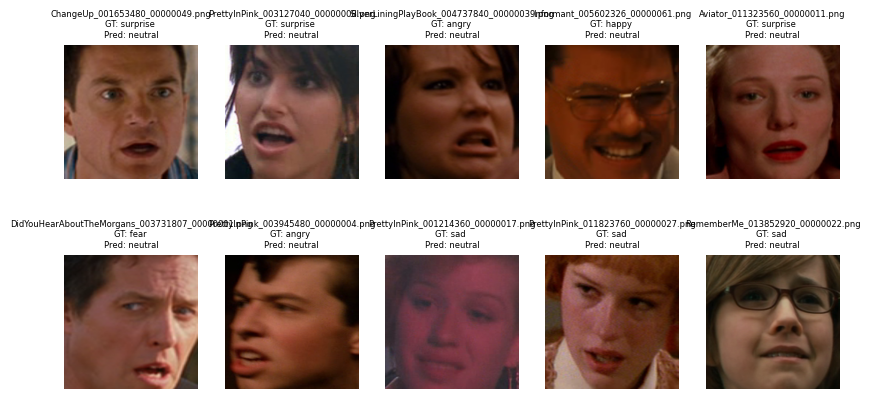

epoch = 2...in DANN execution function
Epoch[2/150] Step[1/58]: loss_total=2.0035 / domain_loss_target=0.6695 / domain_loss_source=0.6970 / task_loss=0.6370 / domain_loss=1.3340 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[11/58]: loss_total=1.8659 / domain_loss_target=0.5992 / domain_loss_source=0.7442 / task_loss=0.5225 / domain_loss=1.2667 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[21/58]: loss_total=2.1768 / domain_loss_target=0.7010 / domain_loss_source=0.7259 / task_loss=0.7500 / domain_loss=1.4758 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[31/58]: loss_total=1.6788 / domain_loss_target=0.6030 / domain_loss_source=0.7733 / task_loss=0.3024 / domain_loss=1.0757 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[41/58]: loss_total=1.9619 / domain_loss_target=0.5821 / domain_loss_source=0.7145 / task_loss=0.6653 / domain_loss=1.3798 / alpha=1.00 / lr=0.001000
Epoch[2/150] Step[51/58]: loss_total=2.1657 / domain_loss_target=0.5596 / domain_loss_source=0.7775 / task_loss=0.8286 / domain

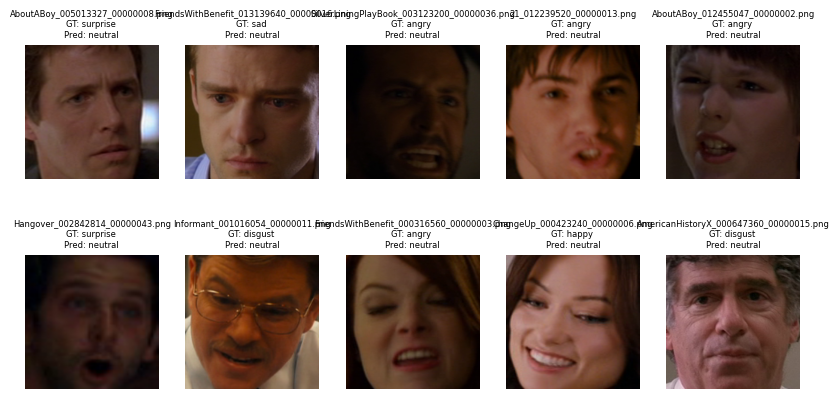

epoch = 12...in DANN execution function
Epoch[12/150] Step[1/58]: loss_total=1.5913 / domain_loss_target=0.6961 / domain_loss_source=0.6461 / task_loss=0.2491 / domain_loss=0.8952 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[11/58]: loss_total=1.3134 / domain_loss_target=0.6782 / domain_loss_source=0.6233 / task_loss=0.0119 / domain_loss=0.6351 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[21/58]: loss_total=1.4466 / domain_loss_target=0.6492 / domain_loss_source=0.6757 / task_loss=0.1217 / domain_loss=0.7974 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[31/58]: loss_total=1.3935 / domain_loss_target=0.6866 / domain_loss_source=0.6545 / task_loss=0.0525 / domain_loss=0.7070 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[41/58]: loss_total=1.3387 / domain_loss_target=0.6391 / domain_loss_source=0.6027 / task_loss=0.0969 / domain_loss=0.6997 / alpha=1.00 / lr=0.000200
Epoch[12/150] Step[51/58]: loss_total=1.6137 / domain_loss_target=0.6480 / domain_loss_source=0.6475 / task_loss=0.3183 /

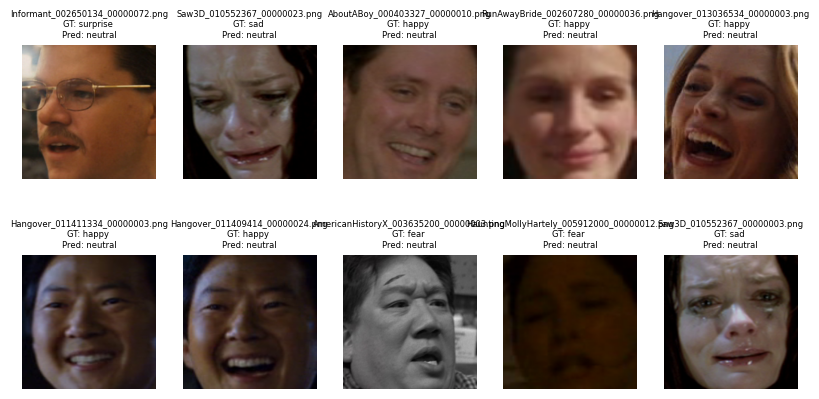

epoch = 22...in DANN execution function
Epoch[22/150] Step[1/58]: loss_total=1.6790 / domain_loss_target=0.7105 / domain_loss_source=0.6516 / task_loss=0.3169 / domain_loss=0.9685 / alpha=1.00 / lr=0.000040
Epoch[22/150] Step[11/58]: loss_total=1.3771 / domain_loss_target=0.6580 / domain_loss_source=0.6480 / task_loss=0.0711 / domain_loss=0.7191 / alpha=1.00 / lr=0.000040
Epoch[22/150] Step[21/58]: loss_total=1.4697 / domain_loss_target=0.7543 / domain_loss_source=0.6470 / task_loss=0.0684 / domain_loss=0.7154 / alpha=1.00 / lr=0.000040
Epoch[22/150] Step[31/58]: loss_total=1.3926 / domain_loss_target=0.7071 / domain_loss_source=0.6448 / task_loss=0.0408 / domain_loss=0.6856 / alpha=1.00 / lr=0.000040
Epoch[22/150] Step[41/58]: loss_total=1.4426 / domain_loss_target=0.7135 / domain_loss_source=0.6566 / task_loss=0.0725 / domain_loss=0.7291 / alpha=1.00 / lr=0.000040
Epoch[22/150] Step[51/58]: loss_total=1.6282 / domain_loss_target=0.6549 / domain_loss_source=0.6359 / task_loss=0.3375 /

In [59]:
print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                    source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                    target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                    target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain,
                                                    scheduler = scheduler,
                                                    early_stop_patience = early_stop_patience,
                                                    early_stop_difference = early_stop_difference
                                                    )

### DANN Saving

In [60]:
dann_model_name = f'dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' # "dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(dann_model_name)

# from data_config import DataConfig
dataconfig_1 = DataConfig()
MODEL_DIR = dataconfig_1.MODEL_DIR

DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'dann_{source_name}_{target_name}'))


if not DANN_MODEL_DIR.exists():
    # Create the directory
    DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {DANN_MODEL_DIR} already exists.')


try:
    torch.save(dann_model_trained.state_dict(), Path(DANN_MODEL_DIR,dann_model_name))
    print(f'{dann_model_name} SAVED at {Path(DANN_MODEL_DIR,dann_model_name)}!')
except:
    print(f'Problem in saving {dann_model_name}, NOT SAVED!')

dann_sfew_expw_11_04.pt
Directory /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw already exists.
dann_sfew_expw_11_04.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/dann_sfew_expw/dann_sfew_expw_11_04.pt!


## EWC DANN Execution: Training, Validating, Saving

In [61]:
model_dann_ewc


DANN_VGG(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256,

### EWC Code
- Regularization Penalty

In [62]:
from torch.autograd import Variable
from torch.autograd import Function
from da_cv_fer.run_config import RunConfig

runconfig = RunConfig()
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
    if torch.cuda.is_available() and use_cuda:
        t = t.cuda()
    return Variable(t, **kwargs)

class EWC(object):
    def __init__(self, model: nn.Module,
                 data_loader: torch.utils.data.DataLoader
                #  dataset: list
                 ,device=device
                 , class_loss_function = runconfig.criterion_class):

        self.model = model
        # print("----------MODEL--------\n",self.model)
        self.dataset = data_loader
        self.device = device
        self.class_loss_function = class_loss_function

        # creating dictionary of params which required grad
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}

        self._means = {}
        # for n, p in deepcopy(self.params).items():
        for n, p in self.params.items():

            self._means[n] = variable(p.data)

        # print("--------self._means----------------\n", self._means)

        self._precision_matrices = self._diag_fisher()

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)
        # print("--------PRECISION MATRICES----------------\n", precision_matrices)

        self.model.eval()
        for batch in self.dataset:
            self.model.zero_grad()
            batch[0] = batch[0]* 255.0
            images, labels  = variable(batch[0].to(device)), variable(batch[1].to(device))
            class_ouputs, _ , _ = self.model(images) # class_output, domain_output, features
            task_loss =  self.class_loss_function(class_ouputs,labels)
            task_loss.backward() # only calculating the gradients, not updating it
            # print("--------task loss----------------\n", task_loss)

            for n, p in self.model.named_parameters():
              # if type(p.grad)
              if isinstance(p.grad, type(None)):
                pass # parameter value would remain as it is
              else:
                # print(n,":", type(p.grad))
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### EWC DANN Execution Function

In [63]:
def execute_dann_ewc(model,
                     device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss(),
                     EWC_LAMBDA = 0.4, # to understand regularlization
                     scheduler = None,
                     early_stop_patience = None,
                     early_stop_difference = None
                     ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    list_lr = [] # to capture lr changes across epochs
    list_val_correct = [] # to capture validation accuracy over epochs
    list_best_val_correct = [] # to capture best validtion accuracy over epochs


    epoch_converge = 0
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    existing_model = deepcopy(model) # copies params from existing model to another one https://discuss.pytorch.org/t/copying-weights-from-one-net-to-another/1492/2
    model = model.to(device)
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]
    #TODO: Scheduler
    # scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, threshold =  0.0005, verbose = True)

    ewc_object = EWC(existing_model.to(device),
                     data_loader=source_train_loader,
                     device=device,
                     class_loss_function=class_loss_function) # instantiating EWC object, we would use this object for understanding penalty


    # for best model
    best_model = deepcopy(model).to(device) # for best model
    best_val_loss = float('inf') # Initialize variables to track the best validation loss
    best_model_state = None # Initialize variables to track the best model state
    best_val_acc = 0 # Initialize variables to track the best accuracy


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in EWC DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter(target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            # p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            # alpha = 2. / (1. + np.exp(-10 * p)) - 1
            alpha = 1.0
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)


            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_batch[0] = source_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            # Calculating source class loss, regularlized by EWC
            loss_source_class = class_loss_function(source_class_outputs, source_labels) + EWC_LAMBDA * ewc_object.penalty(model)# calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_batch[0] = target_batch[0] * 255.0  # Convert inputs from [0, 1] to [0, 255]

            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device) # Target Image == [0., 1.]

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            curr_lr = optimizer.param_groups[0]['lr'] # current learning rate
            list_lr.append(curr_lr)


            # after 10 batches
            if (batch_idx % 50 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f} / lr={:.6f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha,
                      curr_lr
                      ))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        # #Scheduler
        # if scheduler:
        #   scheduler.step(avg_train_task_loss) ## applying scheduler on training loss

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model_local(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)
        list_val_correct.append(correct)

        # # Check if the current model has the best validation loss
        # print(f'Last Epoch Val Loss = {avg_val_task_loss} | Best Val Loss = {best_val_loss}' )
        # if avg_val_task_loss < best_val_loss:
        #   best_val_loss = avg_val_task_loss
        #   # save the current model state as the best model state
        #   best_model_state = deepcopy(model.state_dict())
        #   print(f'Updated the best model with validation loss: {best_val_loss}\n')


        #Scheduler
        if scheduler:
          scheduler.step(correct) ## applying scheduler on correct, proxy to accuracy

        # check if the current model has the best accuracy
        print (f'last correct ={correct} | best correct = {best_val_acc}')
        if correct > best_val_acc:
          best_val_acc = correct
          # save the current model state as the best model state
          best_model_state = deepcopy(model.state_dict())
          print(f'Updated the best model with correct: {correct}\n')

        list_best_val_correct.append(best_val_acc)

        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required
          if early_stopping_difference(list_val_correct,
                                       patience = early_stop_patience,
                                       difference= early_stop_difference):
            print (f'-------Early Stopping at epoch {epoch_idx + 1}---')
            epoch_converge = epoch_idx +1
            break # break from epoch loop
        #TODO: Early Stopping
        if early_stop_patience and early_stop_difference: # early stopping required based on best accuracy
          if early_stopping_difference(list_best_val_correct,
                                       patience = 2* early_stop_patience,
                                       difference= 0):
            print (f'-------Early Stopping at epoch {epoch_idx +1}---')
            epoch_converge = epoch_idx +1
            break # break from epoch loop

    # Testing when the training is over - completed or early stopped

    ## using params of best model to update model
    if best_model_state: # only update if best model has been saved, else the last one would be picked up
      model.load_state_dict(best_model_state)
      print('Best model loaded')

    correct_source, test_loss_source = test_model_local(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    accuracy_source = correct_source / len(source_val_loader.dataset)

    correct_target, test_loss_target = test_model_local(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    accuracy_target = correct_target / len(target_val_loader.dataset)


    dict_ewc_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : epoch_converge,
                        'list_alpha' : list_alpha,
                        'test_accuracy_source' : accuracy_source,
                        'test_accuracy_target':accuracy_target,
                            'lr':list_lr}

    # print(f'alpha list \n {list_alpha}')
    return model, dict_ewc_dann_losses



### EWC DANN Execution Config

In [64]:
runconfig = RunConfig()
lr_ewc_dann = runconfig.inital_lr #override
lr_ewc_dann = 0.001 #override

optimizer_ewc_dann = optim.SGD(model_dann_ewc.parameters(), lr = lr_ewc_dann, momentum = 0.9)
# n_epochs = runconfig.EPOCHS if int(dict_non_dann_losses['epoch_convergence']) == 0 else int(dict_non_dann_losses['epoch_convergence'])

# n_epochs = 40 # override
# n_epochs =  3 # override
n_epochs = runconfig.EPOCHS


# # ReduceLRonPlateau Scheduler Params
# scheduler_patience = runconfig.scheduler_patience
# scheduler_factor = runconfig.scheduler_factor
# scheduler_threshold = runconfig.scheduler_threshold

# # Early stopping params
# early_stop_patience = runconfig.early_stop_patience
# early_stop_difference = runconfig.early_stop_difference


# ReduceLRonPlateau Scheduler Params
scheduler_patience = 8 #runconfig.scheduler_patience
scheduler_factor = runconfig.scheduler_factor
scheduler_threshold = 25 #runconfig.scheduler_threshold

# Early stopping params
early_stop_patience = 10 #runconfig.early_stop_patience
early_stop_difference = 15 #runconfig.early_stop_difference

# # Set up the ReduceLROnPlateau scheduler
# scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
#                               mode='min',
#                               factor=scheduler_factor,
#                               patience=scheduler_patience,
#                               threshold = scheduler_threshold,
#                               min_lr=1e-6,
#                               verbose= True)

scheduler = ReduceLROnPlateau(optimizer_ewc_dann,
                              # mode='min',
                              mode='max',
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              threshold = scheduler_threshold,
                              threshold_mode='abs',
                              min_lr=1e-6,
                              verbose= True)

try:
    EWC_LAMBDA = runconfig.EWC_LAMBDA
except:
    EWC_LAMBDA = 0.4

print(EWC_LAMBDA)


0.4


### EWC DANN Execution

In [65]:
print(f'------------training started for EWC DANN Model ------------------')

ewc_dann_model , dict_ewc_dann_losses = execute_dann_ewc(model= model_dann_ewc,
                                                          device=device,
                                                          source_train_loader = data_loader['source']['train'], #sfew_train_loader,
                                                          source_val_loader = data_loader['source']['val'], #sfew_val_loader,
                                                          target_train_loader = data_loader['target']['train'], #expw_train_loader,
                                                          target_val_loader = data_loader['target']['val'], #expw_val_loader,
                                                          optimizer = optimizer_ewc_dann,
                                                          n_epochs = n_epochs,
                                                          class_loss_function = runconfig.criterion_class,
                                                          domain_loss_function = runconfig.criterion_domain,
                                                          EWC_LAMBDA=EWC_LAMBDA, # Hyperparameter about penalty relevance
                                                          scheduler = scheduler,
                                                          early_stop_patience = early_stop_patience,
                                                          early_stop_difference = early_stop_difference
                                                         )

------------training started for EWC DANN Model ------------------
epoch = 1...in EWC DANN execution function
Epoch [1/150] Step [1/58]: loss_total=1.6559 / domain_loss_target=0.6829 / domain_loss_source=0.6930 / task_loss=0.2800 / domain_loss=0.9730 / alpha=1.0000 / lr=0.001000
Epoch [1/150] Step [51/58]: loss_total=1.7014 / domain_loss_target=0.6433 / domain_loss_source=0.7509 / task_loss=0.3072 / domain_loss=1.0581 / alpha=1.0000 / lr=0.001000
Test / Val: Average loss: 0.1194, Accuracy: 199/419 (47.49%)

last correct =199 | best correct = 0
Updated the best model with correct: 199

epoch = 2...in EWC DANN execution function
Epoch [2/150] Step [1/58]: loss_total=2.4613 / domain_loss_target=0.6475 / domain_loss_source=0.6807 / task_loss=1.1332 / domain_loss=1.8139 / alpha=1.0000 / lr=0.001000
Epoch [2/150] Step [51/58]: loss_total=1.7750 / domain_loss_target=0.6101 / domain_loss_source=0.7385 / task_loss=0.4264 / domain_loss=1.1649 / alpha=1.0000 / lr=0.001000
Test / Val: Average loss

### EWC DANN Saving

In [66]:
# ewc_dann_model_name = 'ewc_dann_sfew_expw_30_01.pt'
ewc_dann_model_name = f'ewc_dann_{source_name}_{target_name}_{str(time.strftime("%d_%m"))}.pt' #"ewc_dann_sfew_expw_" + str(time.strftime("%d_%m")) + ".pt"
print(ewc_dann_model_name)

from da_cv_fer.data_config import DataConfig
dataconfig_2 = DataConfig()
MODEL_DIR = dataconfig_2.MODEL_DIR


EWC_DANN_MODEL_DIR =  Path(os.path.join(MODEL_DIR, f'ewc_dann_{source_name}_{target_name}'))



if not EWC_DANN_MODEL_DIR.exists():
    # Create the directory
    EWC_DANN_MODEL_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {EWC_DANN_MODEL_DIR} created successfully.')
else:
    print(f'Directory {EWC_DANN_MODEL_DIR} already exists.')

try:
    torch.save(ewc_dann_model.state_dict(), Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name))
    print(f'{ewc_dann_model_name} SAVED at {Path(EWC_DANN_MODEL_DIR,ewc_dann_model_name)}!')
except:
    print(f'Problem in saving {ewc_dann_model_name}, NOT SAVED!')

ewc_dann_sfew_expw_11_04.pt
Directory /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw already exists.
ewc_dann_sfew_expw_11_04.pt SAVED at /content/gdrive/MyDrive/CV_FER/models/ewc_dann_sfew_expw/ewc_dann_sfew_expw_11_04.pt!
